# Prepare test data for annotation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
import random
import json
import itertools
from datetime import datetime as dt
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
# custom path
os.chdir('../..')

In [2]:
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

from src.train.predict import prepare_text, load_models, load_test_file, format_text, predict_language


In [4]:
get_file_lang = lambda fp: Path(fp).stem.split('-')[2]

get_translated_file = lambda fp: str(Path(fp).parent.parent / "translated" / f"{Path(fp).stem}-translated.txt")

In [5]:
today_str = dt.strftime(dt.today(), '%Y%m%d')
print(today_str)

20210526


## New randomly selected tasks

In [7]:
FILES = [
    'data/external/r-2/dc0421-input/original/dc0421-input-ru.txt',
    'data/external/r-2/dc0421-input/original/dc0421-input-en.txt',
    'data/external/r-2/dc0421-input/original/dc0421-input-ar.txt',
    'data/external/r-2/dc0421-input/original/dc0421-input-fa.txt',
    'data/external/r-2/dc0421-input/original/dc0421-input-uz.txt',
]
N = 20000

### Load

In [8]:
def update_dict(src_dict,dest_dict):
    src_dict.update(dest_dict)
    return src_dict


def get_task_stats(tasks):
    print('# tasks', len(tasks))
    by_lang = Counter(t['lang_code'] for t in tasks)
    pprint(by_lang)

def filter_list(src, selected):
    return [d for i,d in enumerate(src) if i in selected]


def load_sample(file, size=100):
    lang = get_file_lang(file)
    orig = load_test_file(file, verbose=False)
    n = len(orig)
    selected_ids = random.sample(range(n), min(size, n))
    orig = filter_list(orig, selected_ids)
#     if lang not in ['en','ru']:
    translated_file = get_translated_file(file)
    translated = load_test_file(translated_file, verbose=False)
    translated = filter_list(translated, selected_ids)
    assert len(translated) == len(orig)
    orig = [
        update_dict(o, {
            'title_display': t['title'],
            'description_display': t['description'],
            'recent_posts_display': t['recent_posts'],
    }) for o,t in zip(orig, translated)]
#     else:
#         orig = [
#             update_dict(o, {
#                 'title_display': "",
#                 'description_display': "",
#                 'recent_posts_display': [],
#         }) for o in orig]
    return orig

In [9]:
test_data = {
    get_file_lang(f): load_sample(f, size=N)
    for f in FILES
            }

for l,d in test_data.items():
    print(l, len(d))

ru 13134
en 14319
ar 14324
fa 20000
uz 2446


### eda

#### Average num posts

In [10]:
posts = [(
    lang, 
    one['title'], 
    one['subscribers'],
    len(one['recent_posts']),
) for lang,channels in test_data.items() for one in channels ]

posts = pd.DataFrame(posts, columns=['lang_code', 'title', 'n_subscribers', 'n_posts'])

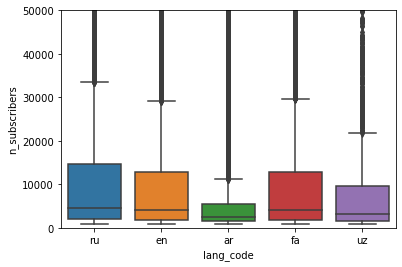

In [11]:
sns.boxplot(x='lang_code', y='n_subscribers', data=posts, );
plt.ylim(0, 50000);

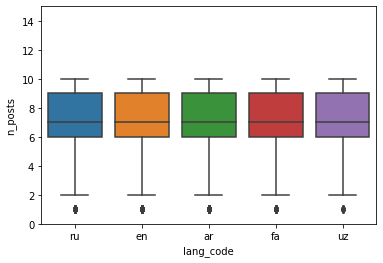

In [12]:
sns.boxplot(x='lang_code', y='n_posts', data=posts, );
plt.ylim(0, 15);

### explore

In [31]:
l = random.choice(list(test_data.keys()))
d = random.choice(test_data[l])

print(f"Language {l.upper()}")
pprint(d)

Language AR
{'counters': {'audios': 0,
              'files': 50,
              'photos': 5072,
              'posts': 34042,
              'videos': 1016},
 'description': 'قناة الاعلامي حسين مرتضى الرسمية على تلغرام',
 'description_display': 'Media Hussein Mortada official channel on Telegram',
 'recent_posts': [{'text': '🔴 وزارة الخارجية والمغتربين: تدين الجمهورية '
                           'العربية السورية بأقوى العبارات النهج العدواني الذي '
                           'تجسد في أعمال الدورة الـ25 لمؤتمر الدول الأطراف في '
                           'منظمة حظر الأسلحة الكيميائية من خلال قيام الدول '
                           'الغربية وخاصة الولايات المتحدة وبريطانيا وفرنسا '
                           'بممارسة أبشع أساليب الابتزاز والتهديد والبلطجة '
                           'والضغوط لتمرير قرار غربي ضد سورية في سابقة خطيرة '
                           'في تاريخ المنظمة.\n'
                           '\n'
                           '■ الخارجية: 45% فقط من الدول الأطراف في اتفاق

### Convert to tasks

In [15]:
tasks = [update_dict(one, {'lang_code':lang}) for lang,channels in test_data.items() for one in channels]



In [16]:
get_task_stats(tasks)

# tasks 600
Counter({'ar': 200, 'fa': 200, 'uz': 200})


In [17]:
random.choice(tasks)

{'title': '• ٢٨ فبراير •',
 'description': '‘لكنَّ الله أحنّ .\U0001f90d\n•\n\n@Reyammkm_bot',
 'subscribers': 1040,
 'counters': {'posts': 1569,
  'photos': 952,
  'videos': 15,
  'audios': 0,
  'files': 0},
 'recent_posts': [{'type': 'photo', 'text': '-زهرو 🌸'},
  {'type': 'text',
   'text': '-أبعدنا يا الله عن كل شئ  يغيرنا\nويخطف ضحكتنا و فرحتنا ويؤذي قلوبنا وأملأنا يارب صبرآ وسعادة وراحة تغنينا عن كل شي'},
  {'type': 'text',
   'text': 'لو خُلِقتُ شعور لوددت أن أكون طمأنينة 💙✨                   \u200f﮼بغداد'},
  {'type': 'text', 'text': '\u200f"أقسى إنفعالاتها.. سكوتها".'},
  {'type': 'photo', 'text': '-اللهم خيراً يصاحب هذه الجمعة ⭐️'},
  {'type': 'text', 'text': '-اللهم أُمي في كُل رمضان 🤲🏻🌙'},
  {'type': 'text',
   'text': 'و كان لديها من اليقين ما يملأ سبع سموات، حتى استجاب الله لها❤️'},
  {'type': 'text',
   'text': 'هم يريدون أن يروك تُبلي حسناً ، ولكن ليس أفضل منهم ، تذكر ذلك'},
  {'type': 'video',
   'text': 'مبارك عليكم شهر الطاعةة والغفران 💕🌙\n#ريام_كريم',
   'duration':

### save tasks

In [18]:
random.shuffle(tasks)

with open(f'data/processed/labelling_tasks_{today_str}.json', 'w') as f:
    json.dump(tasks, f)

## TG labelled data

for reference when labelling

In [7]:
LABELLED_FILES = [
    {
        'input': 'data/external/submission1489/category_en/input.txt',
        'output': 'data/external/submission1489/category_en/tg_output.txt'
    },
    {
        'input': 'data/external/submission1489/category_ru/input.txt',
        'output': 'data/external/submission1489/category_ru/tg_output.txt'
    },
]

In [8]:
get_lang = lambda fp: Path(fp).parent.stem.split('_')[1]

### load files

In [9]:
labelled = {
    get_lang(files['input']): {
        k: load_test_file(file) 
        for k,file in files.items()
    } for files in LABELLED_FILES
}

Loaded 14775 rows
Loaded 14775 rows
Loaded 16726 rows
Loaded 16726 rows


### Show

In [16]:
l = random.choice(list(labelled.keys()))

i = random.randint(0, len(labelled[l]['input']))
inp = labelled[l]['input'][i]
out = labelled[l]['output'][i]

print('Lang', l.upper(),)
print('\nINPUT:')
pprint(inp)
print('\nOUTPUT:')
pprint(out)

Lang EN

INPUT:
{'description': 'the forecast Suggestion time of 5 rounds per day\n'
                'planning time\n'
                '1️⃣ 11 am\n'
                '2️⃣ 2 pm\n'
                '3️⃣ 5 pm\n'
                '4️⃣ 8 pm\n'
                '5️⃣ 9 pm\n'
                'Join link: https:rxce.in/#/register?r_code=X31T2A4W\n'
                'Code- X31T2A4W',
 'recent_posts': ['Withrawal ✅😍',
                  'The first round of red envelope participation conditions, '
                  'the recharge is greater than 100rs or the cumulative amount '
                  'of game transactions is greater than 1000rs\n'
                  'The second round of red envelope participation conditions, '
                  'the recharge is greater than 500rs or the cumulative amount '
                  'of game transactions is greater than 2000rs\n'
                  'The third round of red envelope participation conditions, '
                  'the recharge is greater than 1000rs or the c

### Random select

In [10]:
N = 1000

selected = {}

for l,data in labelled.items():
    selected_ids = random.sample(range(len(data['input'])), N)
    inp = filter_list(data['input'], selected_ids)
    out = filter_list(data['output'], selected_ids)
    selected[l] = [update_dict(i,o) for i,o in zip(inp, out)]



In [ ]:
for l,d in selected.items():
    print(l, len(d))

### Save 

In [17]:
for lang,sel in selected.items():
    with open(f'data/processed/labelled_tgdata_{lang}_{today_str}.json', 'w') as f:
        json.dump(sel, f)

## Save data and configs

In [23]:
from lxml import etree

### generate and save configs

In [24]:
def clean_topic(orig):
    orig = re.split(' [–-] ', orig)[0].strip()
    return orig

In [25]:
TOPICS = """
    Art & Design
    Bets & Gambling – includes sports bets
    Books
    Business & Entrepreneurship
    Cars & Other Vehicles
    Celebrities & Lifestyle
    Cryptocurrencies
    Culture & Events
    Curious Facts
    Directories of Channels & Bots
    Drug Sale
    Economy & Finance
    Education
    Erotic Content
    Fashion & Beauty
    Fitness
    Forgery – includes fake documents, fake money, etc.
    Food & Cooking
    Foreign Language Learning
    Hacked Accounts & Software – includes carding, passwords for subscription services, etc.
    Health & Medicine
    History
    Hobbies & Activities
    Home & Architecture
    Humor & Memes
    Investments
    Job Listings
    Kids & Parenting
    Marketing & PR
    Motivation & Self-development - includes inspirational quotes and poetry
    Movies
    Music
    Offers & Promotions – includes products or services for sale, unless they fall under the newly added categories
    Personal Data – includes doxxing, databases
    Pets
    Pirated Content – films, music, books, but not software
    Politics & Incidents
    Prostitution
    Psychology & Relationships
    Real Estate
    Recreation & Entertainment
    Religion & Spirituality
    Science
    Spam & Fake Followers – includes spam tools and services, boosting followers, likes, etc.
    Sports – includes e-sports
    Technology & Internet
    Travel & Tourism
    Video Games
    Weapon Sale
    Other
""".strip().split('\n')

TOPICS = [clean_topic(t) for t in TOPICS]

len(TOPICS)

50

In [26]:
xml = etree.Element('View')
# headers
_ = etree.SubElement(xml, "Header", size='4', value=f'$lang_code')
# orig text
orig_view = etree.SubElement(xml, 'View')
_ = etree.SubElement(orig_view, "Header", size='4', value=f'$title')
_ = etree.SubElement(orig_view, "Header", size='4', value=f'$description')
_ = etree.SubElement(orig_view, 'Paragraphs', name="posts", value="$recent_posts", nameKey="type", textKey="text", layout="dialogue")
# translated
translated_view = etree.SubElement(xml, 'View')
_ = etree.SubElement(translated_view, "Header", size='4', value=f'$title_display')
_ = etree.SubElement(translated_view, "Header", size='4', value=f'$description_display')
_ = etree.SubElement(translated_view, 'Paragraphs', name="posts", value="$recent_posts_display", nameKey="type", textKey="text", layout="dialogue")
# primary
_ = etree.SubElement(xml, "Header", size="6",
                          value="Primary topics")
_ = etree.SubElement(xml, "Filter", name="filter_primary",
                      toName='primary', hotkey="shift+f",
                      minlength="1", )
primary = etree.SubElement(xml, "Choices", name="primary", toName="posts",
                          showInline="true", choice='multiple', required='true')
_ = [etree.SubElement(primary, 'Choice', value=s, )
     for s in TOPICS]
# secondary
_ = etree.SubElement(xml, "Header", size="6",
                          value="Secondary topics")
_ = etree.SubElement(xml, "Filter", name="filter_secondary",
                      toName='secondary',
                      minlength="1", )
secondary = etree.SubElement(xml, "Choices", name="secondary", toName="posts",
                          showInline="true", choice='multiple', required='false')
_ = [etree.SubElement(secondary, 'Choice', value=s, ) for s in TOPICS]
# pretty string
etree.indent(xml, space='  ')
config = etree.tostring(xml, pretty_print=True,).decode('utf-8')

In [27]:
with open(f'data/processed/labelling_config_{today_str}.xml', 'w') as f:
    f.write(config)

print(config)

<View>
  <Header size="4" value="$lang_code"/>
  <View>
    <Header size="4" value="$title"/>
    <Header size="4" value="$description"/>
    <Paragraphs name="posts" value="$recent_posts" nameKey="type" textKey="text" layout="dialogue"/>
  </View>
  <View>
    <Header size="4" value="$title_display"/>
    <Header size="4" value="$description_display"/>
    <Paragraphs name="posts" value="$recent_posts_display" nameKey="type" textKey="text" layout="dialogue"/>
  </View>
  <Header size="6" value="Primary topics"/>
  <Filter name="filter_primary" toName="primary" hotkey="shift+f" minlength="1"/>
  <Choices name="primary" toName="posts" showInline="true" choice="multiple" required="true">
    <Choice value="Art &amp; Design"/>
    <Choice value="Bets &amp; Gambling"/>
    <Choice value="Books"/>
    <Choice value="Business &amp; Entrepreneurship"/>
    <Choice value="Cars &amp; Other Vehicles"/>
    <Choice value="Celebrities &amp; Lifestyle"/>
    <Choice value="Cryptocurrencies"/>
    <